<a href="https://colab.research.google.com/github/nahum0804/TallerDeProgramacion-Project/blob/main/Reconocer_rostros_Dylan_y_Nahum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica | TEC
# Carrera de Ingeniería en Computación 
# I Semestre de 2023
# Proyecto Programado (Fase I – Entrevistador asistido por IA) 
# Dr. Abel Méndez Porras
# amendez@itcr.ac.cr
# Porcentaje: 20%

# Entrevistador asistido por IA



El reconocimiento facial y la detección de emociones son tecnologías que se han vuelto cada vez más populares en los últimos años. Estas tecnologías utilizan algoritmos de inteligencia artificial para analizar imágenes y detectar patrones faciales que permiten identificar a las personas y sus emociones.
En cuanto a las oportunidades, el reconocimiento facial puede tener aplicaciones en la seguridad, el marketing y la atención al cliente. Por ejemplo, en la seguridad se pueden utilizar sistemas de reconocimiento facial para identificar a personas en lugares públicos o para controlar el acceso a edificios y sistemas de seguridad. En el marketing, se pueden utilizar para personalizar la publicidad en función de la edad, el género y otros datos demográficos. Y en la atención al cliente, se pueden utilizar para detectar la satisfacción del cliente en tiempo real y responder adecuadamente.

En esta primera etapa del proyecto del curso de Taller de Programación estaremos utilizando los resultados de consultas a modelos de Deep Learning para aplicar los conocimientos adquiridos en clase. 

## Objetivo
Desarrollar una aplicación de complejidad baja que permita poner en práctica los conocimientos adquiridos en los cursos de Introducción a la Programación y Taller de Programación.
## Objetivos Específicos
*   Identificar los requerimientos para resolver un problema específico desde la perspectiva de resolución de problemas, técnicas con listas y diccionarios.
*   Diseñar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas y diccionarios.
*.  Desarrollar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas y diccionarios.

## Configuración previa 

### Cargar Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Leer cámara
Tomado de https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb



### Importar dependencies

In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

### Convertir el objeto JavaScript un objeto OpenCV image

In [3]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Crear nuestro live video stream

In [4]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Iniciar streaming video

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [6]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import model_from_json

### Cargar modelos de Deep Learning entrenados

*   Para detectar los rostros se utiliza el modelo de Face Haar Cascade.
*   Para detectar las emociones se utiliza el modelo de VGG.
*   También se utiliza un algoritmo adicional para pasar la información del algortimo de VGG a un formato JSON.

Estos modelos y algoritmos están disponibles en el siguiente enlace [Descargar modelos y algoritmos](https://drive.google.com/drive/folders/1KctA_s25bqqMOUlQuy0lwTm0HkBGVycF?usp=sharing). Usted los debe colocar en su Google Drive y modificar la ruta de acceso. 



In [7]:
#Cargar modelos de Deep Learning entrenados
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/projectFiles/haarcascade_frontalface_alt.xml') 
model = model_from_json(open("/content/drive/MyDrive/projectFiles/model.json", "r").read()) 
model.load_weights('/content/drive/MyDrive/projectFiles/model.h5') 


Crear interfaz
https://www.youtube.com/watch?v=oIVmV41uyK8

#Entrevista personal

## Recolectar información personal



Información requerida al entrevistar una persona (Toda esta información debe ser almacenada en un diccionario. Cada diccionario de cada entrevista debe ser colocado en una lista. Se maneja una lista principal donde se tiene todas las entrevistas de las personas).
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección
*   Estado civil
*   Cantidad de hijos indicando el género, la fecha de nacimiento(un diccionario) 
*   Entrevistas (cada persona puede ser entrevistada cero o más veces). Las entrevistas se realizan en tiempo real utilizando una camára integrada a la computadora o externa (el profesor facilita el código para activar la camára, capturar el video y capturar los frames cada cierto tiempo). Se debe crear una lista con sublistas donde cada sublista tiene las imagenes capturas y las emociones reportadas durante la entrevista. Además, debe guardar coordenadas donde se encuentra el rostro en la imagen. Para cada entrevista, el entrevistado debe contar historias cortas sobre los siguientes 4 tópicos:


  >*   Una experiencia de sorpresa o asombro que ha tenido que vivir.
  >*   Una experiencia de tristeza que ha tenido que vivir.
  >*   Una experiencia de enojo o frustración que ha tenido que vivir.
  >*   Una experiencia de felicidad que ha tenido que vivir.




In [ ]:
#Global variables
userList = []
dictionaryList = []

def createUserAndAttributesFace():

  """ Create user dictionary """

  while True:

    dictionaryList = []

    name = input("Enter your name: ")

    dictionary = dict()
    dictionary[name] = dict()
    dictionary[name]["ID"] = input("Enter your ID: ")
    dictionary[name]["age"] = input("Age (In years old): ")
    dictionary[name]["gender"] = input("Gender: (Male/Female)")
    dictionary[name]["Nacionality"] = input("Enter your nacionality: ")
    dictionary[name]["Cellphone"] = dict()
   
    i = 1
    while True:
      cellphone = input("Cellphone: ")
      dictionary[name]["Cellphone"][f"Cellphone-{i}"] = cellphone
      i += 1
      option = input("You want add another cellphone number? Y/N: ")
      if option == "Y":
       continue
      elif option == "N":
        break
      else:
        print("Invalid option - (You most enter the options in capital letters!)")
        break

    dictionary[name]["email"] = []
    while True:
      email = input("Email: ")
      dictionary[name]["email"].append(email)
      option = input("You want add another email? Y/N: ")
      if option == "Y":
       continue
      elif option == "N":
        break
      else:
        print("Invalid option - (You most enter the options in capital letters!)")
        break

    dictionary[name]["location"] = input("Enter your location: ")
    dictionary[name]["civilStatus"] = input("Enter your civil status: ")
    dictionary[name]["children"] = dict()
    children = input("Do you have children? Y/N: ")
    if children == "Y":
      valid = True
      while valid:
        nameChild = input("Name: ")
        gender = input("Gender: ")
        age = input("Age (In years old): ")

        dictionary[name]["children"][nameChild] = dict()
        dictionary[name]["children"][nameChild]["gender"] = gender
        dictionary[name]["children"][nameChild]["age"] = age

        option = input("You want add another child? Y/N: ")
        if option == "Y":
          continue
        elif option == "N":
          valid = False
        else:
          print("Invalid option - (You most enter the options in capital letters!)")
          valid = False
    elif children == "N":
      pass
    else:
      print("Invalit option")


    dictionary[name]["imagesCaptured"] = [] 

    dictionary[name]["Checked"] = False

    dictionaryList.append(dictionary) #Agregar el diccionario a la lista
    userList.append(dictionaryList)

    print(userList)

    select = input("You want continue adding users? Y/N: ")
    if select == "Y":
      continue
    elif select == "N":
      break
    else:
      print("Invalid option - (You most enter the options in capital letters!)")
      break
      



createUserAndAttributesFace()

count = 1 #Variable a usar en siguiente celda

j = 1 #Variable a usar para el nombre aka numero de las imagenes generadas


## Recolectar información emociones
Este código se encarga de ejecutar la captura de video de la cámara, detectar los rostros en las imágenes y reconocer las emociones presentes en los rostros. Cuando se hace la entrevista es en este código donde usted de obtener la información para crear las listas con la información solicitada.

In [ ]:
from tensorflow.python.ops.math_ops import sign
# start streaming video from webcam

video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

imagesData = dict()
facesDataList = []

nameInput = input("Ingrese su nombre antes de comenzar la entrevista: ")

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  img_copy = img

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  listaX = [] #Lista que agrega elementos a la lista padre

  if count == j: #El tiempo para capturar el frame y procesarlo
    #Este sería el path de la imagen guardada
    image_path ='/content/drive/MyDrive/projectFiles/imagesGained/' + 'nombre' + str(j) +  '.jpg'
    imagesData["image_path"] = image_path
    #se guarda el fotograma con el "nombre" más el número del contador i
    cv2.imwrite(image_path , img) 
    
    #Detectar los rostros usando Face Haar Cascade
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #En faces_deteted se encuentran los rotros detectados
    faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.32,5)
    imagesData["Location"] = faces_detected
    #Imprimir ubicación de los rostros en la imagen
    #print("Ubicación del rostro:", faces_detected)
    im2Display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imTemp = im2Display.copy()

    #Hacer un rectángulo en cada rostro detectado en la imagen
    for (x,y,w,h) in faces_detected:
         cv2.rectangle(img,(x,y), (x+w,y+h), (255,0,0), thickness=7)

         roi_gray=gray_image[y:y+w,x:x+h]
         roi_gray=cv2.resize(roi_gray,(48,48))

         #Processes the image and adjust it to pass it to the model
         image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
       
         image_pixels = np.expand_dims(image_pixels, axis = 0)
         image_pixels /= 255

         #Obtener las emociones para cada rostro detectado en la imagen
         #Get the prediction of the model
         predictions = model.predict(image_pixels)
         #Mostrar todas las emociones detectadas
         #print("Predicciones: ", predictions)
         #Mostrar la emoción más significativa (con el valor más alto)
         max_index = np.argmax(predictions[0])
         #print(max_index, predictions[0])
         #El orden en que vienen las emociones
         emotion_detection = ('angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral')

         emotion_prediction = emotion_detection[max_index]
         #Crear un diccionario para almacenar la emoción y el valor para la emoción
         frame_dic = dict(
              angry = predictions[0][0],
              disgust = predictions[0][1],
              fear = predictions[0][2],            
              happiness = predictions[0][3],
              sadness = predictions[0][4],
              surprise = predictions[0][5],
              neutral = predictions[0][6]) 
         #print("Predicciones: ", frame_dic)
         imagesData["emotions"] = frame_dic
         #print(emotion_prediction)
        
         #Mostrar en la imagen un texto de la emoción más significativa
         ubicacion = (x,y)
         font = cv2.FONT_HERSHEY_TRIPLEX
         tamañoLetra = 2
         colorLetra = (221,82,196)
         grosorLetra = 7
         #Escribir texto con la emoción más significativa
         cv2.putText(imTemp, emotion_prediction, ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
         pt1 = (x, y)
         pt2 = (x+w, y+h)
         color = (23,200,54)
         thickness = 10
         cv2.rectangle(imTemp, pt1, pt2, color, thickness)

        #-------Adding captured data----------------

         listaX.append(imagesData)
         facesDataList.append(listaX)
        
         for i in userList:
           if list(i[0].keys())[0] == nameInput:
             dataGained = i[0]
             if dataGained[nameInput]["Checked"] == False:

                imagesData = dict()

                imagesData = dict()
                imagesData["image_path"] = image_path
                imagesData["emotions"] = frame_dic
                imagesData["Location"] = faces_detected

                listaX = []
                listaX.append(imagesData) #Sublista para agregar los elementos a la lista padre

                dataGained[nameInput]["imagesCaptured"].append(listaX)
             else:
                print("Este usuario ya realizó la entrevista, por lo cual sus datos no serán recopilados")

         j += 1

        #-------Adding captured data----------------


    #Mostrar la imagen con los cuadros en los rostros y el texto de la emoción más significativa
    plt.imshow(imTemp)
    plt.show()

  count +=1

dataGained[nameInput]["Checked"] = True 
print(userList)

**1)**

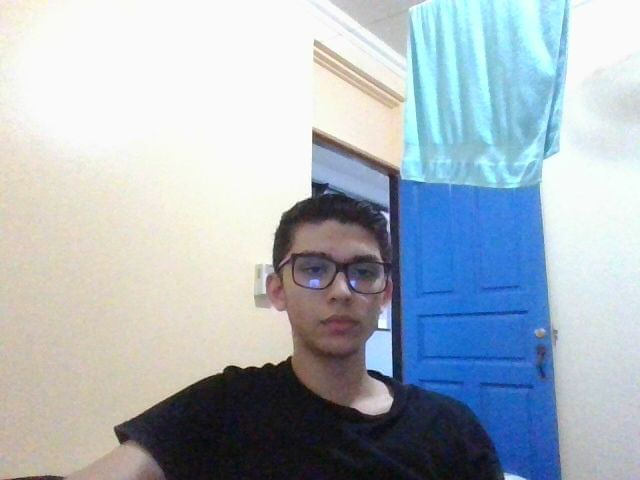

Emotions:
 angry: 9.06%
 disgust: 0.05%
 fear: 5.00%
 happiness: 0.60%
 sadness: 12.19%
 surprise: 0.75%
 neutral: 72.35%
Location face:  [[275 221 130 130]]


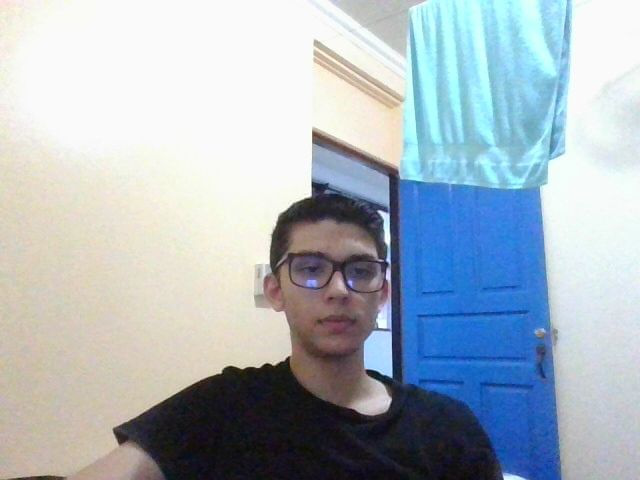

Emotions:
 angry: 6.31%
 disgust: 0.08%
 fear: 2.81%
 happiness: 8.21%
 sadness: 6.40%
 surprise: 1.32%
 neutral: 74.87%
Location face:  [[271 219 130 130]]


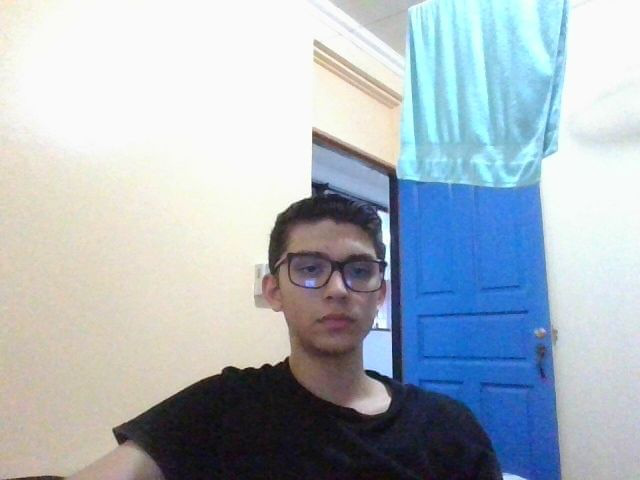

Emotions:
 angry: 14.69%
 disgust: 0.12%
 fear: 10.05%
 happiness: 0.42%
 sadness: 22.88%
 surprise: 0.80%
 neutral: 51.05%
Location face:  [[270 219 133 133]]


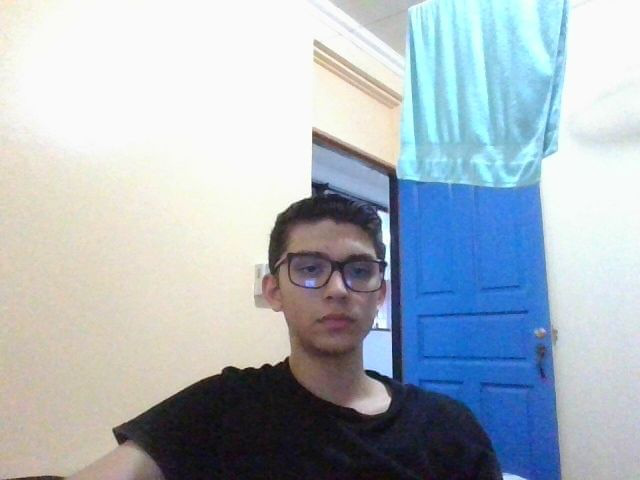

Emotions:
 angry: 14.69%
 disgust: 0.12%
 fear: 10.05%
 happiness: 0.42%
 sadness: 22.88%
 surprise: 0.80%
 neutral: 51.05%
Location face:  [[270 219 133 133]]


DATA:
Name: Dylan A
ID: 208570188
Age (In years old): 23
Nacionality: Costarricense
Cellphone: 
 Cellphone-1: 87125788 
Emails:
 asndjnaos@gmail.com
Location: Santa Clara
Civil Status: Casado
Children: 
 Noelia info: 
  gender: Female
  age: 14
Images Captured: ------------------------------------------------------


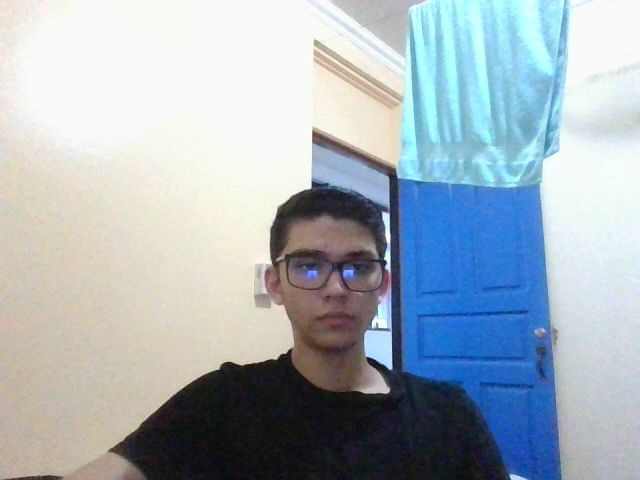

Emotions:
 angry: 13.35%
 disgust: 0.10%
 fear: 9.88%
 happiness: 0.39%
 sadness: 19.75%
 surprise: 1.15%
 neutral: 55.39%
Location face:  [[268 213 128 128]]


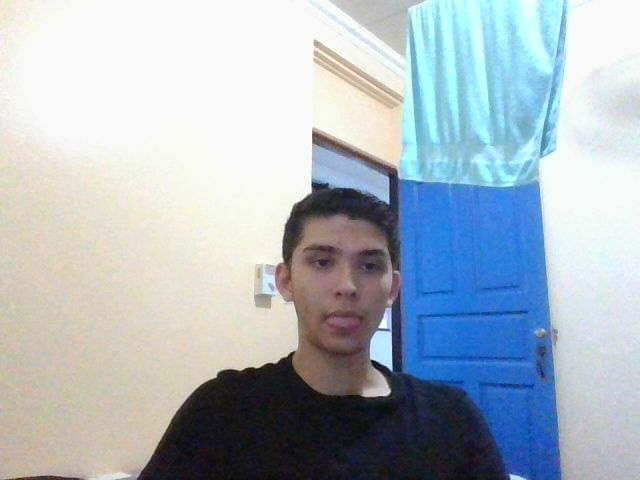

Emotions:
 angry: 8.82%
 disgust: 0.09%
 fear: 17.70%
 happiness: 0.32%
 sadness: 35.74%
 surprise: 0.58%
 neutral: 36.75%
Location face:  [[286 217 120 120]]


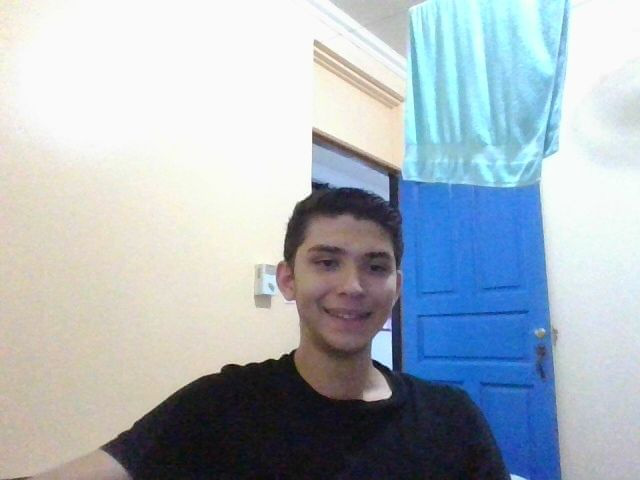

Emotions:
 angry: 0.11%
 disgust: 0.00%
 fear: 0.07%
 happiness: 96.36%
 sadness: 0.18%
 surprise: 0.06%
 neutral: 3.22%
Location face:  [[287 214 126 126]]


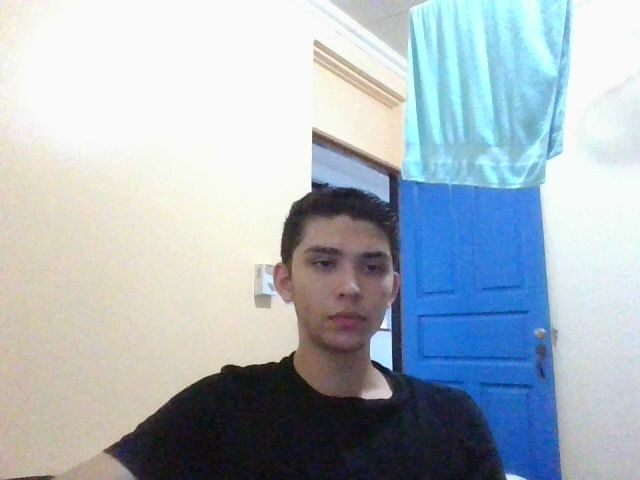

Emotions:
 angry: 8.48%
 disgust: 0.05%
 fear: 13.26%
 happiness: 0.10%
 sadness: 46.38%
 surprise: 0.10%
 neutral: 31.63%
Location face:  [[280 211 137 137]]


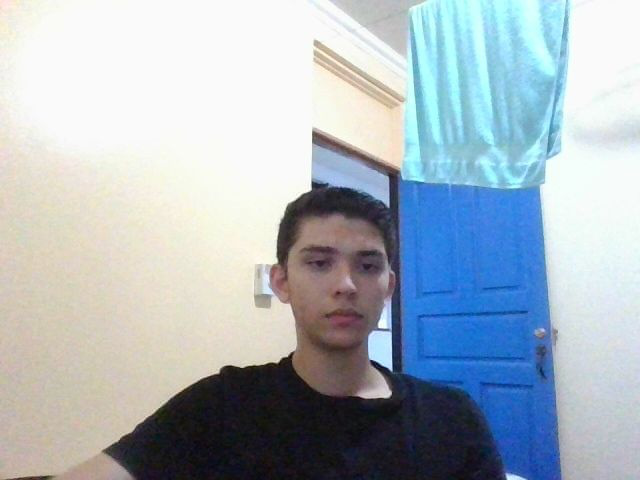

Emotions:
 angry: 10.39%
 disgust: 0.16%
 fear: 20.37%
 happiness: 0.43%
 sadness: 37.55%
 surprise: 0.75%
 neutral: 30.36%
Location face:  [[283 216 123 123]]


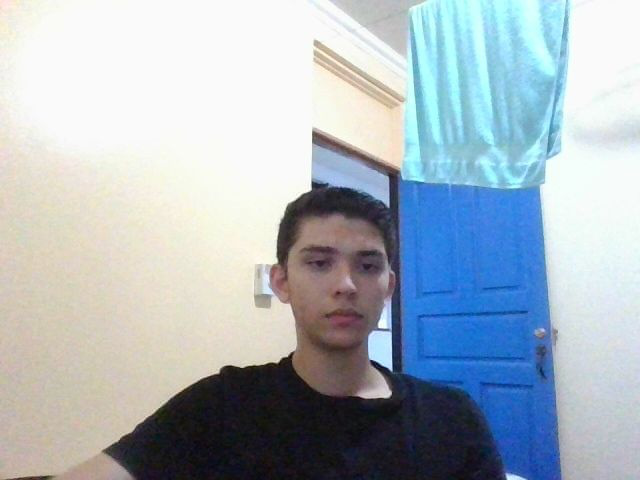

Emotions:
 angry: 10.39%
 disgust: 0.16%
 fear: 20.37%
 happiness: 0.43%
 sadness: 37.55%
 surprise: 0.75%
 neutral: 30.36%
Location face:  [[283 216 123 123]]


DATA:
Name: Dylan
ID: 208570199
Age (In years old): 18
Nacionality: Costarricense
Cellphone: 
 Cellphone-1: 87125755 
Emails:
 dylanjimenezalfaro.ml@gmail.com
Location: Santa Clara
Civil Status: Soltero
Dont have children
Images Captured: ------------------------------------------------------




In [35]:
from PIL import Image 

#Diccionary for testing

#userList = [[{'Nahum Murillo': {'ID': '208560927', 'age': '30-08-2004', 'Nacionality': 'Costa Rican', 'Cellphone': {'Cellphone-1': '6070-6962', 'Cellphone-2': '2473-0116'}, 'email': ['n4hummuro227@gmail.com', 'namurillo@estudiantec.cr'], 'location': 'Santa Clara', 'civilStatus': 'Single', 'children': {}, 'imagesCaptured': [[{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre3.jpg', 'emotions': {'angry': 0.06608227, 'disgust': 0.00039380527, 'fear': 0.12798952, 'happiness': 0.002801901, 'sadness': 0.43129727, 'surprise': 0.0013236789, 'neutral': 0.37011153}, 'Location': array([[165,  75, 239, 239]], dtype=int32)}], [{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre4.jpg', 'emotions': {'angry': 0.0008574802, 'disgust': 1.2938146e-05, 'fear': 0.0009918537, 'happiness': 0.9748403, 'sadness': 0.0022587792, 'surprise': 0.0007153148, 'neutral': 0.020323334}, 'Location': array([[176,  84, 223, 223]], dtype=int32)}], [{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre5.jpg', 'emotions': {'angry': 0.0008574802, 'disgust': 1.2938146e-05, 'fear': 0.0009918537, 'happiness': 0.9748403, 'sadness': 0.0022587792, 'surprise': 0.0007153148, 'neutral': 0.020323334}, 'Location': ()}]], 'Checked': True}}], [{'Dylan Jimenez': {'ID': '208570199', 'age': '08-09-2004', 'Nacionality': 'Costarricense', 'Cellphone': {'Cellphone-1': '87125755'}, 'email': ['dylanjimenezalfaro@gmail.com'], 'location': 'Santa Clara', 'civilStatus': 'Soltero', 'children': {}, 'imagesCaptured': [[{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre1.jpg', 'emotions': {'angry': 0.11027633, 'disgust': 0.0013947216, 'fear': 0.14113344, 'happiness': 0.009197275, 'sadness': 0.29542413, 'surprise': 0.008586974, 'neutral': 0.4339872}, 'Location': array([[183, 164, 184, 184]], dtype=int32)}]], 'Checked': True}}]]


for i in userList:
  dictionaryData = i[0]

  name = list(dictionaryData.keys())[0]  #  Nombre de cada diccionario

  print("DATA:")

  print(f"Name: {name}")  #Imprimir nombre de usuario que posee la lista
  print(f"ID: {dictionaryData[name]['ID']}")
  print(f"Age (In years old): {dictionaryData[name]['age']}")
  print(f"Nacionality: {dictionaryData[name]['Nacionality']}")

  print("Cellphone: ")
  for x in dictionaryData[name]['Cellphone']:
    number = str(dictionaryData[name]['Cellphone'][x])
    print(f" {x}: {number} ")
  
  print("Emails:")
  for x in dictionaryData[name]['email']:
    print(f" {x}")

  print(f"Location: {dictionaryData[name]['location']}")
  print(f"Civil Status: {dictionaryData[name]['civilStatus']}")

  if dictionaryData[name]['children'] == {}:
    print("Dont have children")
  else:
    print("Children: ")
    childrenList = dictionaryData[name]['children']
    childrenOrder = 0
    for i in childrenList:
      print(f" {list(dictionaryData[name]['children'])[childrenOrder]} info: ")
      nameChild = list(dictionaryData[name]['children'])[childrenOrder]
      print(f"  {list(dictionaryData[name]['children'][i])[0]}: {dictionaryData[name]['children'][nameChild]['gender']}")
      print(f"  {list(dictionaryData[name]['children'][i])[1]}: {dictionaryData[name]['children'][nameChild]['age']}")
      childrenOrder += 1



  print("Images Captured: ------------------------------------------------------")

  for y in dictionaryData[name]['imagesCaptured']:
    for z in y:
      urlImg = list(z.items())[0][1]
      emotionsDict = list(z.items())[1][1]
      locationFace = list(z.items())[2][1]

      img = Image.open(urlImg)
      img.show() 

      emotions = list(emotionsDict.keys())
      print("Emotions:")
      for e in emotions:
        
        print(f" {e}: {'{:.2f}'.format(emotionsDict[e] * 100)}%")

      print("Location face: ",locationFace)
  print("\n")

**2)**

In [61]:
for user in userList:
  print(user)

def sort_by_age_insertion(lst):
    for i in range(0, len(lst)):
        current_value = lst[i]
        current_age = int(list(current_value[0].values())[0]['age'])
        j = i - 1
        while j >= 0 and int(list(lst[j][0].values())[0]['age']) > current_age:
            lst[j+1] = lst[j]
            j -= 1
        lst[j+1] = current_value
    return lst

sorted_data = sort_by_age_insertion(userList)

[{'Dylan': {'ID': '208570199', 'age': '18', 'gender': 'Male', 'Nacionality': 'Costarricense', 'Cellphone': {'Cellphone-1': '87125755'}, 'email': ['dylanjimenezalfaro.ml@gmail.com'], 'location': 'Santa Clara', 'civilStatus': 'Soltero', 'children': {}, 'imagesCaptured': [], 'Checked': False}}]
[{'Dylan J': {'ID': '208570199', 'age': '21', 'gender': 'Male', 'Nacionality': 'Costarricense', 'Cellphone': {'Cellphone-1': '87545359'}, 'email': ['asjdalsdjl@gmail.com'], 'location': 'Santa Clara', 'civilStatus': 'Casado', 'children': {'Ana': {'gender': 'Female', 'age': '8'}, 'Pedro': {'gender': 'Male', 'age': '10'}}, 'imagesCaptured': [[{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre8.jpg', 'emotions': {'angry': 0.0015216859, 'disgust': 1.8299192e-05, 'fear': 0.0011033552, 'happiness': 0.93580735, 'sadness': 0.0027026935, 'surprise': 0.0012532359, 'neutral': 0.057593353}, 'Location': array([[266, 219, 125, 125]], dtype=int32)}], [{'image_path': '/content/drive/MyDrive/pro

**3)**

In [40]:
data = userList

n = len(data)
for i in range(n-1):
    for j in range(n-i-1):
        if len(list(data[j][0].values())[0].get('children', {})) < len(list(data[j+1][0].values())[0].get('children', {})):
            data[j], data[j+1] = data[j+1], data[j]

for i in data:
  print(i)


[{'Dylan J': {'ID': '208570199', 'age': '21', 'gender': 'Male', 'Nacionality': 'Costarricense', 'Cellphone': {'Cellphone-1': '87545359'}, 'email': ['asjdalsdjl@gmail.com'], 'location': 'Santa Clara', 'civilStatus': 'Casado', 'children': {'Ana': {'gender': 'Female', 'age': '8'}, 'Pedro': {'gender': 'Male', 'age': '10'}}, 'imagesCaptured': [[{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre8.jpg', 'emotions': {'angry': 0.0015216859, 'disgust': 1.8299192e-05, 'fear': 0.0011033552, 'happiness': 0.93580735, 'sadness': 0.0027026935, 'surprise': 0.0012532359, 'neutral': 0.057593353}, 'Location': array([[266, 219, 125, 125]], dtype=int32)}], [{'image_path': '/content/drive/MyDrive/projectFiles/imagesGained/nombre9.jpg', 'emotions': {'angry': 0.09061691, 'disgust': 0.0004982147, 'fear': 0.050022025, 'happiness': 0.0060038134, 'sadness': 0.121893786, 'surprise': 0.0074929236, 'neutral': 0.7234723}, 'Location': array([[275, 221, 130, 130]], dtype=int32)}], [{'image_path': '/

**4)**

**5)**

In [19]:
listWithSublists = []

for user in userList:
  userListGeneral = []

  listUserData = []
  listUserEmotions = []

  userDict = user[0]

  userName = list(userDict)[0]
  userId = userDict[userName]['ID']
  # userGender = userDict[userName]['gender']
  userAge = userDict[userName]['age']

  listUserData.append(userName)
  listUserData.append(userId)
  listUserData.append(userAge)


  emotions = list(userDict[userName]['imagesCaptured'])
  for e in emotions:
    userEmotionsSublist = []
    emotionsList = list(e[0]['emotions'])
    for eL in emotionsList:
      userEmotionsSublist.append(e[0]['emotions'][eL])
    
    listUserEmotions.append(userEmotionsSublist)

  userListGeneral.append(listUserData)
  userListGeneral.append(listUserEmotions)

  listWithSublists.append(userListGeneral)

print(listWithSublists)
  
  # for e in emotions:      
    # print(f" {e}: {'{:.2f}'.format(emotionsDict[e] * 100)}%")


[[['Dylan', '208570199', '18'], [[0.11254102, 0.0013026876, 0.12881581, 0.0065072663, 0.24902202, 0.011852331, 0.4899589], [0.010265498, 0.00033421276, 0.011863136, 0.8964549, 0.019682923, 0.004764372, 0.05663489], [0.004999963, 9.530001e-05, 0.0041457633, 0.9038163, 0.0077813473, 0.0033244025, 0.0758369], [0.2514784, 0.034220282, 0.22373787, 0.007431009, 0.358151, 0.014608905, 0.11037257], [0.2514784, 0.034220282, 0.22373787, 0.007431009, 0.358151, 0.014608905, 0.11037257]]]]


**6)**

In [20]:
def quicksort(list1):
    if len(list1) <= 1:
        return list1
    else:
        pivote = list1[0]
        left = []
        right = []
        for i in range(1, len(list1)):
            if list1[i][4] < pivote[4]:
                left.append(list1[i])
            else:
                right.append(list1[i])
        return quicksort(left) + [pivote] + quicksort(right)


print("List without changes: ")
print(listWithSublists)

print("Sublists without changes: ")
for x in listWithSublists:
  print(x)

print("\n")

indice = 0
for x in listWithSublists:
  listaOrdenada = quicksort(listWithSublists[indice][1])
  listWithSublists[indice].pop(1)
  listWithSublists[indice].insert(1, listaOrdenada)
  indice += 1


print("List changed: ")
print(listWithSublists)

print("Sublists changed: ")
for x in listWithSublists:
  print(x)


List without changes: 
[[['Dylan', '208570199', '18'], [[0.11254102, 0.0013026876, 0.12881581, 0.0065072663, 0.24902202, 0.011852331, 0.4899589], [0.010265498, 0.00033421276, 0.011863136, 0.8964549, 0.019682923, 0.004764372, 0.05663489], [0.004999963, 9.530001e-05, 0.0041457633, 0.9038163, 0.0077813473, 0.0033244025, 0.0758369], [0.2514784, 0.034220282, 0.22373787, 0.007431009, 0.358151, 0.014608905, 0.11037257], [0.2514784, 0.034220282, 0.22373787, 0.007431009, 0.358151, 0.014608905, 0.11037257]]]]
Sublists without changes: 
[['Dylan', '208570199', '18'], [[0.11254102, 0.0013026876, 0.12881581, 0.0065072663, 0.24902202, 0.011852331, 0.4899589], [0.010265498, 0.00033421276, 0.011863136, 0.8964549, 0.019682923, 0.004764372, 0.05663489], [0.004999963, 9.530001e-05, 0.0041457633, 0.9038163, 0.0077813473, 0.0033244025, 0.0758369], [0.2514784, 0.034220282, 0.22373787, 0.007431009, 0.358151, 0.014608905, 0.11037257], [0.2514784, 0.034220282, 0.22373787, 0.007431009, 0.358151, 0.014608905, 0.

**7)**

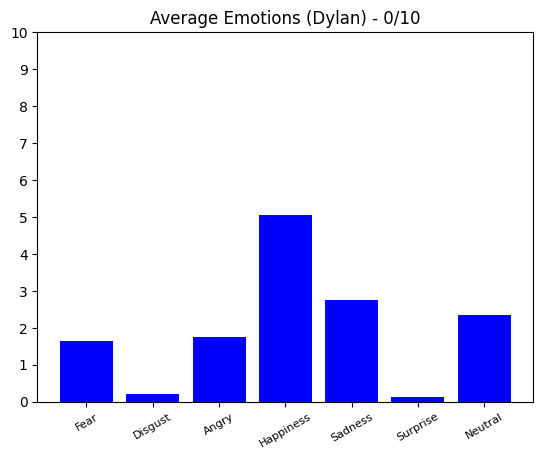

--------------!!!!!!!!!!--------------------------


In [21]:
import matplotlib.pyplot as plt

def graphic_quarter(numbers, labels, pos, nombre):
    plt.title(f'Average Emotions ({nombre}) - 0/10')
    plt.bar(pos, numbers, color='blue')
    plt.xticks(ticks=pos, labels=labels, fontsize=8, rotation=30)
    plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    plt.show()

#Create emotionList - Average numbers



for i in userList:

  n = 1 #Length

  avFear = 0
  avDisgust = 0
  avAngry = 0
  avHappiness = 0
  avSadness = 0
  avSurprise = 0 
  avNeutral = 0

  nombre = list(i[0].keys())[0]
  for j in i[0][nombre]["imagesCaptured"]:
    emotions = list(j[0]["emotions"].keys())
    for z in emotions:
       if z == "fear":
         avFear += j[0]["emotions"][z]
       elif z == "disgust":
         avDisgust += j[0]["emotions"][z]
       elif z == "angry":
         avAngry += j[0]["emotions"][z]
       elif z == "happiness":
         avHappiness += j[0]["emotions"][z]
       elif z == "sadness":
         avSadness += j[0]["emotions"][z]
       elif z == "surprise":
         avSurprise += j[0]["emotions"][z]
       elif z == "neutral":
         avNeutral  += j[0]["emotions"][z]
       n += 1


  avFear = avFear / n
  avDisgust = avDisgust / n
  avAngry = avAngry / n
  avHappiness = avHappiness / n
  avSadness = avSadness / n
  avSurprise = avSurprise / n
  avNeutral = avNeutral / n

  if __name__ == '__main__':
    listaEmociones = [avFear*100, avDisgust*100, avAngry*100, avHappiness*100, avSadness*100, avSurprise*100, avNeutral*100]
    labels = ['Fear', 'Disgust', 'Angry', 'Happiness','Sadness', 'Surprise', 'Neutral']
    pos = list(range(7))
    graphic_quarter(listaEmociones, labels, pos, nombre)
    print("--------------!!!!!!!!!!--------------------------")



**8)**

# Consultas


1.   Mostrar la información de todas las personas entrevistas (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

2.   Mostrar la información de todas las personas entrevistas ordenada ascendentemente por edad. El método de ordenamiento a utilizar es el método por inserción (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

3.   Mostrar la información de todas las personas entrevistas ordenada descendente mente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la bubuja (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

4. Mostrar la información de todas las personas entrevistas ordenada descendentemente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la quicksort (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros. También, imprimir una lista con sublistas donde la primera sublista tiene la información de las personas que tienen únicamente hijos de género femenino, la segunda sublista tiene información de personas que tienen únicamente hijos de género masculino y la última sublista tiene información de personas que tienen hijos tanto de género femenino como másculino. 

5. Obtener para cada persona entrevistada las emociones sin ordenar y guardar en una lista (una lista por entrevista) con sublistas la siguiente información: en la primera sublista colocar la identificación, el nombre, el género y la edad de la persona entrevistada, en las siguientes sublistas colocar las emociones expresadas por la persona. Por ejemplo, si la persona apareció en 10 fotogramas entonces se deben crear 10 sublistas, cada sublista pertenece a las emociones emitidas por el candidato en un fotograma. 

6. Una vez creada esta listas (una por entrevista) con sublistas del punto anterior, se debe ordenar las sublistas de forma ascendente por la emoción felicidad (happiness) utilizando el técnica de ordenamiento Quicksort.

7. Para cada persona entrevistada muestre un gráfico para comparar las emociones reportadas durante la entrevista.

8. Incluya en el documento escrito la entrevista a dos personas. De aportar toda la información recolectada, las imágenes recolectadas en la entrevista con un cuadro en los rostros presentes. Además, debe mostrar la información de las emociones reportadas. Por último, incluya un análisis de la importancia de este tipo de algoritmos y de la importancia de la privacidad de la información en este tipo de sistemas.




## Aspectos administrativos


* La tarea será desarrollada en equipos de trabajo de máximo 2 personas.
* Cualquier acción de plagio será sancionada con una nota de 0 y la carta al expediente respectiva para todos los
implicados.
* La fecha de entrega será la semana 11, el día de clases, antes de la hora de clases.
* Para llevar el control de versiones del proyecto se debe crear un repositorio en GitLab y agregar al profesor (agregarlo
a la cuenta amendez.tec@gmail.com).
* Para llevar el control del las tareas a realizar por participante en el proyecto debe utilizar la herramienta
https://trello.com/es y compartir el link en el mismo Google Doc en que se comparte el link de la plantilla de Overleaf. Pueden crear tab de todas las tareas o requerimientos, un tab para las tareas en proceso y un tab para las tareas hechas.
* La codificación y documentación interna deberá ser desarrollada en idioma inglés utilizando el estándar docString de Python.
*La documentación externa debe estar redactada en idioma inglés utilizando la herramienta Overleaf (utilizar la plantilla facilitada por el profesor). La documentación es evaluada en el curso de Introducción a la programación.
* Documentación del Código utilizando Docstring Conventions 	
* Introducción a Python la Guía de Estilo de Código en Python
* La entrega será mediante la plataforma TecDigital en el espacio de Proyecto – Etapa 1. Lo que debe subir es un archivo de tipo notebook cuya extensión es (.ipynb). Además, en este archivo deben venir los enlaces a las imagenes utilizados para la tarea.
* Se recomienda que se empiece a trabajar lo antes posible.



# "La programación es una habilidad que puedes cultivar en ti mismo y usar para cambiar el mundo". - Barack Obama